In [69]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning) #Using this to avoid clustering in outputs
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

import torch
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [70]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root="cnn_dataset", transform=transform) 
train_data, test_data = random_split(dataset, [0.8, 0.2])
train_train_data, val_data = random_split(train_data, [0.8, 0.2])

trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
testloader = DataLoader(test_data, batch_size=32, shuffle=True)
valdataloader = DataLoader(val_data, batch_size=32, shuffle=True)

print(type(trainloader))

<class 'torch.utils.data.dataloader.DataLoader'>


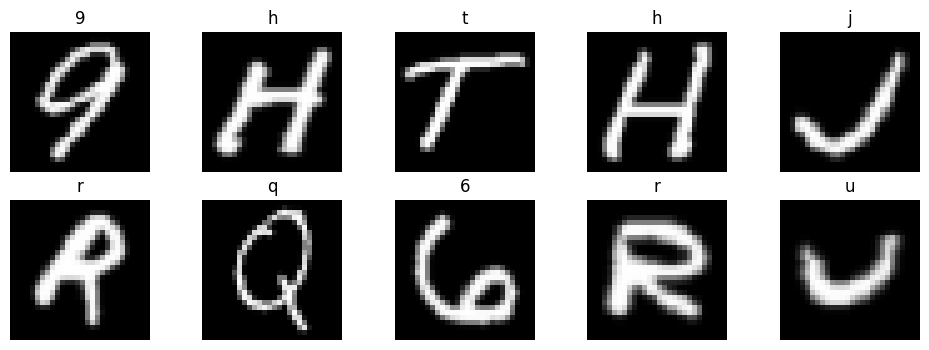

In [71]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import rgb_to_grayscale

classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]

fig, axes = plt.subplots(2, 5, figsize=(12, 4))

dataloader = DataLoader(dataset)
index = 0
for row in range(2):
    for col in range(5):
        dataiter = iter(trainloader)
        train_features, train_labels = next(dataiter)
        img = rgb_to_grayscale(train_features[0]).squeeze()
        axes[row, col].imshow(img, cmap="gray")
        axes[row, col].axis('off')
        axes[row, col].set_title(classes[train_labels[0]])
        index += 1    

In [72]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, features_in, features_out, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(features_in, features_out, 3, stride=stride, padding=1),
            nn.BatchNorm2d(features_out),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(features_out, features_out, 3, stride=1, padding=1),
            nn.BatchNorm2d(features_out)
        )
        self.relu = nn.ReLU()
        self.shortcut = None
        if stride != 1 or features_in != features_out: # to make connection, when input and output features are of different sizes
            self.shortcut = nn.Sequential(
                nn.Conv2d(features_in, features_out, 1, stride=stride),
                nn.BatchNorm2d(features_out)
            )

    def forward(self, x):
        conn = x
        x = self.conv1(x)
        x = self.conv2(x)
        if self.shortcut != None:
            x += self.shortcut(conn)
        x = self.relu(x)

        return x

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1)
        )

        self.conv2 = nn.Sequential(
            BasicBlock(64, 64),
            BasicBlock(64, 64),
            BasicBlock(64, 64),
        )

        self.conv3 = nn.Sequential(
            BasicBlock(64, 128, 2),
            BasicBlock(128, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 128),
        )

        self.conv4 = nn.Sequential(
            BasicBlock(128, 256, 2),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
        )

        self.conv5 = nn.Sequential(
            BasicBlock(256, 512, 2),
            BasicBlock(512, 512),
            BasicBlock(512, 512),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.output = nn.Linear(512, 36)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.output(x)

        return x

model = ResNet()

In [73]:
import torch.optim as optim

model = ResNet() 

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [74]:
train_losses = []
validation_losses = []
test_losses = []

train_accuracies = []
validation_accuracies = []
test_accuracies = []

import time
start_time = time.time()
print("Start Time: ", start_time)
print()
best_val_accuracy = 0
best_model = None
counter = 0
early_stop = 3
for epoch in range(5):
    print("Epoch: ", epoch + 1)
    #Training
    print("Training.")
    predictions_arr = []
    labels_arr = []
    train_loss = 0
    train_accuracy = 0
    count = 1
    acc_count = 0
    correct_pred = 0
    for data in trainloader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predictions = torch.max(outputs.data, 1)
        acc_count += len(predictions)
        for x, y in zip(predictions, labels):
            predictions_arr.append(x)
            labels_arr.append(y)
            if x == y:
                correct_pred += 1
        if count % 2000 == 0:
            train_losses.append(train_loss/(len(trainloader)/8))
            # print(train_loss/(len(trainloader)/8))
            train_loss = 0
        count += 1
    train_accuracies.append((correct_pred/acc_count))

    #Validation
    print("Validating..")
    validation_loss = 0
    validation_accuracy = 0
    count = 1
    predictions_arr = []
    labels_arr = []
    correct_pred = 0
    acc_count = 0
    with torch.no_grad():
        for data in valdataloader:
            images, labels = data
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            optimizer.step()
            validation_loss += loss.item()
            _, predictions = torch.max(outputs.data, 1)
            acc_count += len(predictions)
            for x, y in zip(predictions, labels):
                predictions_arr.append(x)
                labels_arr.append(y)
                if x == y:
                    correct_pred += 1
            if count % 400 == 0:
                validation_losses.append(validation_loss/(len(valdataloader)/8))
                # print(train_loss/(len(trainloader)/8))
                validation_loss = 0
            count +=1
        validation_accuracy = correct_pred/acc_count
        validation_accuracies.append(validation_accuracy)
    
    if validation_accuracy - best_val_accuracy > 1:
        best_val_accuracy = validation_accuracy
        best_model = model
        counter = 0
    else:
        counter += 1
    
    #Testing
    print("Testing...")
    count = 1
    predictions_arr = []
    labels_arr = []
    test_loss = 0
    acc_count = 0
    correct_pred = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            optimizer.step()
            test_loss += loss.item()
            _, predictions = torch.max(outputs.data, 1)
            for x, y in zip(predictions, labels):
                predictions_arr.append(x)
                labels_arr.append(y)
                if x == y:
                    correct_pred += 1
            acc_count += len(predictions)
            if count % 500 == 0:
                test_losses.append(test_loss/(len(testloader)/8))
                # print(test_loss/(len(testloader)/8))
                test_loss = 0
            count += 1
        test_accuracies.append((correct_pred/(acc_count)))
    print()
    if early_stop != None and counter > early_stop:
        break

end_time = time.time()
print("End Time: ", start_time)
print("Train time: ", end_time - start_time)
print(count)

Start Time:  1699916003.4492834

Epoch:  1
Training.
Validating..
Testing...

Epoch:  2
Training.
Validating..
Testing...

Epoch:  3
Training.
Validating..
Testing...

Epoch:  4
Training.
Validating..
Testing...

End Time:  1699916003.4492834
Train time:  3801.9364972114563
631


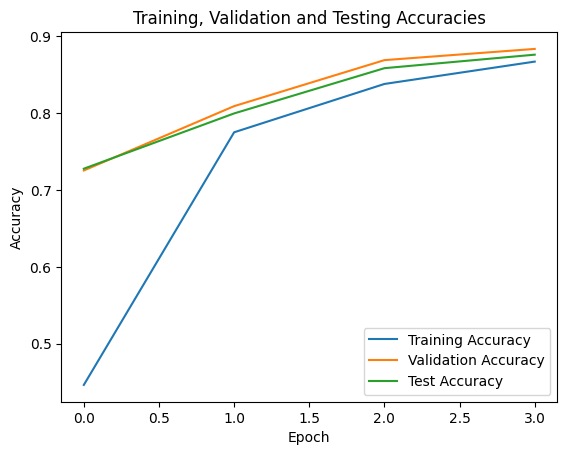

In [75]:
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training, Validation and Testing Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

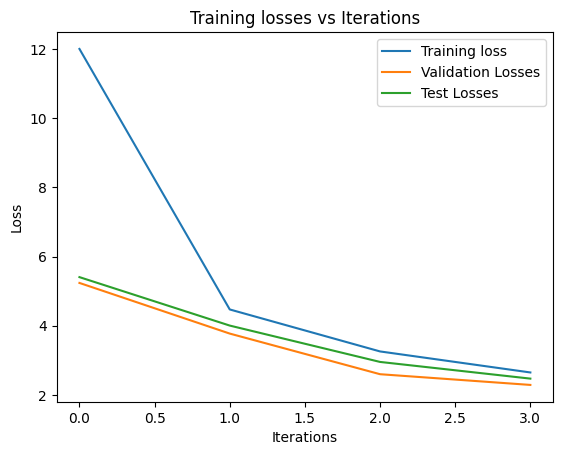

In [76]:
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label="Validation Losses")
plt.plot(test_losses, label="Test Losses")
plt.title('Training losses vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [77]:
correct_pred = 0
count = 0
predictions_arr = []
labels_arr = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs.data, 1)
        for x, y in zip(predictions, labels):
            predictions_arr.append(x)
            labels_arr.append(y)
            if x == y:
                correct_pred += 1
        count += len(predictions)

print(f'Test Accuracy:', (correct_pred/count)*100)

Test Accuracy: 87.58928571428571


In [78]:
predicted_labels = []
true_labels = []
for x in predictions_arr:
    predicted_labels.append(classes[x.item()])

for x in labels_arr:
    true_labels.append(classes[x.item()])

print(predicted_labels)
print(true_labels)

['3', 'j', 'h', 'u', '7', 'e', '1', 'r', 'j', 'y', 'a', 'b', 'v', 'i', 'u', '7', 'a', 'p', 'n', 'h', 'o', 'n', 'f', 'p', 'f', '5', 'y', 'p', 'b', 'a', 'm', 'q', 'b', 'r', 'm', 'u', 'b', '7', 'q', 'u', 'a', 'c', '9', 'o', 'm', 'y', 'u', 'y', '5', 'x', 'o', 't', '7', 'd', 'r', 'r', '7', 'q', 'c', '0', 'u', 'p', 'i', 'r', 'y', '2', '4', 'y', 'v', 'b', 'i', 'c', '5', 'e', '5', 'g', '0', 'h', '5', 'e', 'r', 'f', '0', 'a', '9', 'h', 'i', 'b', 's', 'k', '2', 'w', 'a', 'g', 'i', 'k', 't', 'y', 'd', 'o', 'c', '7', 'u', 'c', 'd', 'k', 's', 'c', 's', 'c', 'w', '2', 'h', 'u', '0', '3', 'k', 'm', 's', 'u', 'n', 'd', 'w', '2', 'p', 'w', '6', 'd', '6', 'b', 'v', '2', 'y', 'h', '2', '5', 'g', '8', 'x', '4', 'b', 'f', '4', 'n', '4', '3', 'l', 'q', 'k', 'b', 'f', 'o', 'm', 'x', 'w', '9', '3', 'i', 'i', 'k', 'i', 'b', '7', 'n', 'e', 'i', 'a', 'n', '5', '3', 'f', 'd', '1', '4', 'm', 'c', '3', 't', 'h', '0', '3', 'm', 'n', '6', '5', '8', 'o', 'c', 'h', 'x', 'w', '8', 'k', '9', 'm', 'e', 'j', 'j', 'y', 's',

In [79]:
from sklearn.metrics import precision_recall_fscore_support
print(type(predictions_arr))
print(type(labels_arr))
print(predictions_arr)
print(labels_arr)
precision, recall, fscore, support = precision_recall_fscore_support(y_true=labels_arr, y_pred=predictions_arr, average='macro')
print("Precision:", precision, "\nRecall: ", recall, "\nF-Score: ", fscore, "\nSupport: ", support)

<class 'list'>
<class 'list'>
[tensor(3), tensor(19), tensor(17), tensor(30), tensor(7), tensor(14), tensor(1), tensor(27), tensor(19), tensor(34), tensor(10), tensor(11), tensor(31), tensor(18), tensor(30), tensor(7), tensor(10), tensor(25), tensor(23), tensor(17), tensor(24), tensor(23), tensor(15), tensor(25), tensor(15), tensor(5), tensor(34), tensor(25), tensor(11), tensor(10), tensor(22), tensor(26), tensor(11), tensor(27), tensor(22), tensor(30), tensor(11), tensor(7), tensor(26), tensor(30), tensor(10), tensor(12), tensor(9), tensor(24), tensor(22), tensor(34), tensor(30), tensor(34), tensor(5), tensor(33), tensor(24), tensor(29), tensor(7), tensor(13), tensor(27), tensor(27), tensor(7), tensor(26), tensor(12), tensor(0), tensor(30), tensor(25), tensor(18), tensor(27), tensor(34), tensor(2), tensor(4), tensor(34), tensor(31), tensor(11), tensor(18), tensor(12), tensor(5), tensor(14), tensor(5), tensor(16), tensor(0), tensor(17), tensor(5), tensor(14), tensor(27), tensor(15), te

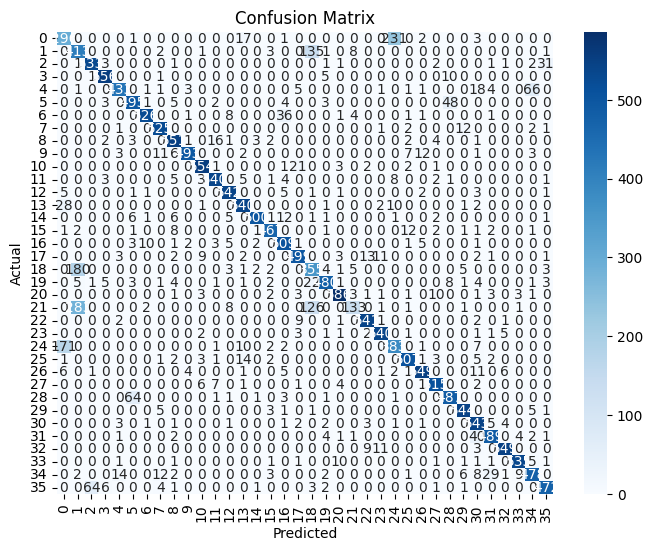

In [80]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

confusion_mat = confusion_matrix(true_labels, predicted_labels)

class_names = [str(i) for i in range(len(np.unique(predictions_arr)))]

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


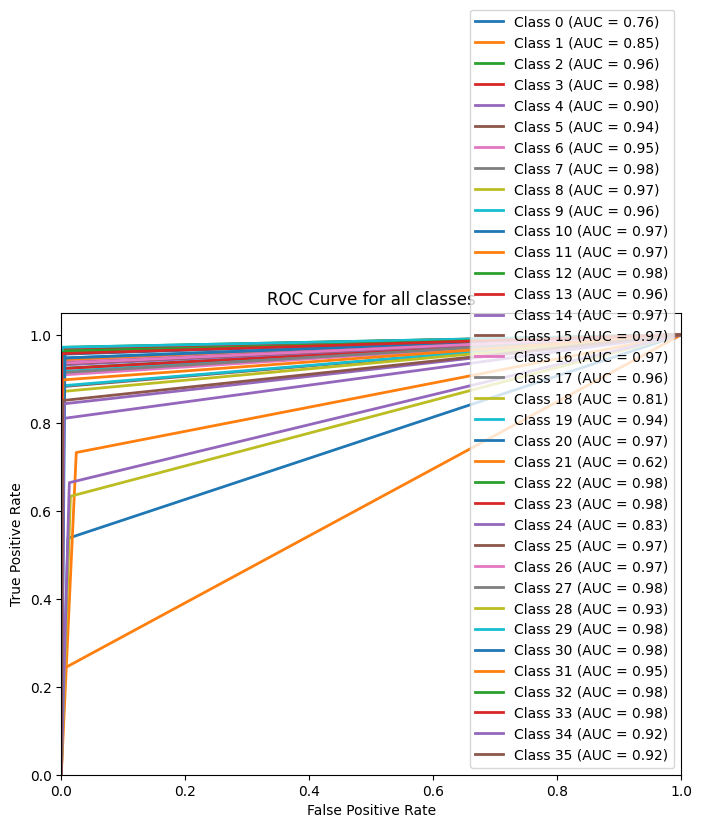

In [81]:
from sklearn.metrics import roc_curve, auc
roc_data = {}

predicted_labels = np.array(predictions_arr)

num_classes = len(np.unique(predictions_arr))

for class_index in range(num_classes): 
    binary_true_labels = [1 if label == class_index else 0 for label in labels_arr]
    
    fpr, tpr, _ = roc_curve(binary_true_labels, predicted_labels == class_index)
    roc_auc = auc(fpr, tpr)
    
    roc_data[class_index] = (fpr, tpr, roc_auc)


plt.figure(figsize=(8, 6))
for class_index in range(num_classes):
    fpr, tpr, roc_auc = roc_data[class_index]
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_index} (AUC = {roc_auc:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for all classes')
plt.legend(loc='lower right')
plt.show()

References


In [82]:
#https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
#https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders
#https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html#resnet34
#https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf
#https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
#https://pytorch.org/docs/stable/optim.html
#https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
#https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
#https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
#https://pytorch.org/ignite/generated/ignite.handlers.early_stopping.EarlyStopping.html
#https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
#https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#
#https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
#https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
#https://pytorch.org/docs/stable/optim.html